Dataset Link : https://drive.google.com/drive/folders/1iSiJF65ETUXOwSSjEvT8WGclvG63CjqS?usp=sharing

# Heart Beat Audio Anomaly Classification

In [122]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier, 
                              StackingClassifier, AdaBoostClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa, librosa.display
import IPython.display as ipd
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc



# Feature Extraction

In [123]:
folder_path =r"C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave"

data = []

# Function to extract label from filename
def extract_label(filename):
    if 'normal' in filename:
        return 'normal'
    elif 'artifact' in filename:
        return 'artifact'
    elif 'murmur' in filename:
        return 'murmur'
    elif 'extrastole' in filename:
        return 'extrastole'
    elif 'extrahls' in filename:  
        return 'extrahls'
    else:
        return 'unknown'  


for filename in os.listdir(folder_path):
    if filename.endswith('.wav'):  
        label = extract_label(filename)
        
        # Load audio file
        file_path = os.path.join(folder_path, filename)
        y, sr = librosa.load(file_path)

     
        if np.max(np.abs(y)) < 1e-6:  
            print(f"Warning: The file {filename} is silent or has very low amplitude.")
            continue  

        try:

            mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=100), axis=1)
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
            centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85))
            chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))  
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue  

       
        features = np.hstack([mfcc, [zero_crossing_rate, centroid, rolloff, chroma]])
        data.append([filename, label] + features.tolist())


columns = ['wave_name', 'label'] + [f'mfcc{i+1}' for i in range(100)] + ['zero', 'centroid', 'rolloff', 'chroma']
df = pd.DataFrame(data, columns=columns)


df.to_csv('wave_features.csv', index=False)

print("DataFrame with wave names, labels, and features created successfully!")

C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\librosa\core\pitch.py:101: UserWarning:

Trying to estimate tuning from empty frequency set.



DataFrame with wave names, labels, and features created successfully!


In [124]:
df = df.drop(columns=['wave_name'])

In [125]:
df.head()

,label,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc95,mfcc96,mfcc97,mfcc98,mfcc99,mfcc100,zero,centroid,rolloff,chroma
0,artifact,-594.029114,38.685055,5.528633,5.631157,3.402866,1.321780,-0.979730,-2.110061,-3.675011,...,-0.033450,-0.135073,-0.171531,-0.247917,-0.269179,-0.263613,0.335732,3579.996058,6985.720731,0.647074
1,artifact,-594.029114,38.685055,5.528633,5.631157,3.402866,1.321780,-0.979730,-2.110061,-3.675011,...,-0.033450,-0.135073,-0.171531,-0.247917,-0.269179,-0.263613,0.335732,3579.996058,6985.720731,0.647074
2,artifact,-594.029114,38.685055,5.528633,5.631157,3.402866,1.321780,-0.979730,-2.110061,-3.675011,...,-0.033450,-0.135073,-0.171531,-0.247917,-0.269179,-0.263613,0.335732,3579.996058,6985.720731,0.647074
3,artifact,-594.029114,38.685055,5.528633,5.631157,3.402866,1.321780,-0.979730,-2.110061,-3.675011,...,-0.033450,-0.135073,-0.171531,-0.247917,-0.269179,-0.263613,0.335732,3579.996058,6985.720731,0.647074
4,artifact,-750.833496,29.685860,-4.507759,-2.470312,-4.913467,-1.428128,-1.864766,0.225090,-4.211215,...,-0.497894,0.109580,-0.288746,0.144825,-0.134265,0.027769,0.484600,5173.122204,7950.719019,0.610578


In [126]:
df['label'].unique()

array(['artifact', 'extrahls', 'extrastole', 'murmur', 'normal'],
      dtype=object)

## EDA

#### Normal

In [127]:
def soundwave(path):

    sampFreq, sound_normal = wavfile.read(path)
    

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle("Sound Analysis", fontsize=16)

    # First subplot: Original sound waveform
    axs[0, 0].plot(sound_normal, 'r')
    axs[0, 0].set_title("Original Sound Wave")
    axs[0, 0].set_xlabel("Sample")
    axs[0, 0].set_ylabel("Amplitude")

    # Second subplot: FFT Spectrum
    fft_spectrum = np.fft.rfft(sound_normal)
    freq = np.fft.rfftfreq(sound_normal.size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
    axs[0, 1].plot(freq, fft_spectrum_abs)
    axs[0, 1].set_title("FFT Spectrum")
    axs[0, 1].set_xlabel("Frequency (Hz)")
    axs[0, 1].set_ylabel("Amplitude")

    # Third subplot: Waveform using Librosa
    data, frame = librosa.load(path)
    librosa.display.waveshow(sound_normal.astype(np.float32), sr=sampFreq, ax=axs[1, 0])
    axs[1, 0].set_title("Librosa Waveform")
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Amplitude")

    # Fourth subplot: MFCCs
    hop_length = 512  
    n_fft = 2048
    MFCCs = librosa.feature.mfcc(y=data, sr=frame, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)
    img = librosa.display.specshow(MFCCs, sr=frame, hop_length=hop_length, ax=axs[1, 1], cmap='viridis')
    axs[1, 1].set_title("MFCCs")
    axs[1, 1].set_xlabel("Time")
    axs[1, 1].set_ylabel("MFCC Coefficients")
    fig.colorbar(img, ax=axs[1, 1], format="%+2.f dB")

   
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()




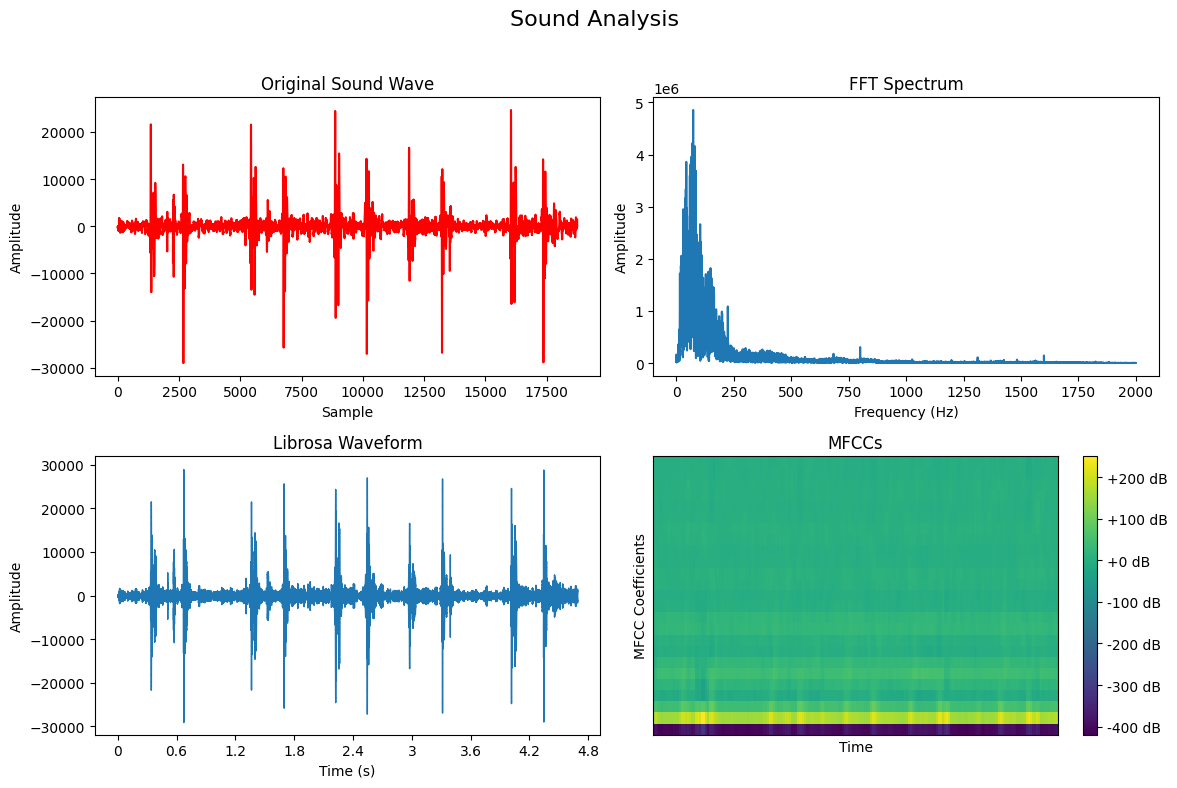

In [128]:
soundwave(r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\normal_noisynormal_198_1308141739338_D.wav')

### Murmur

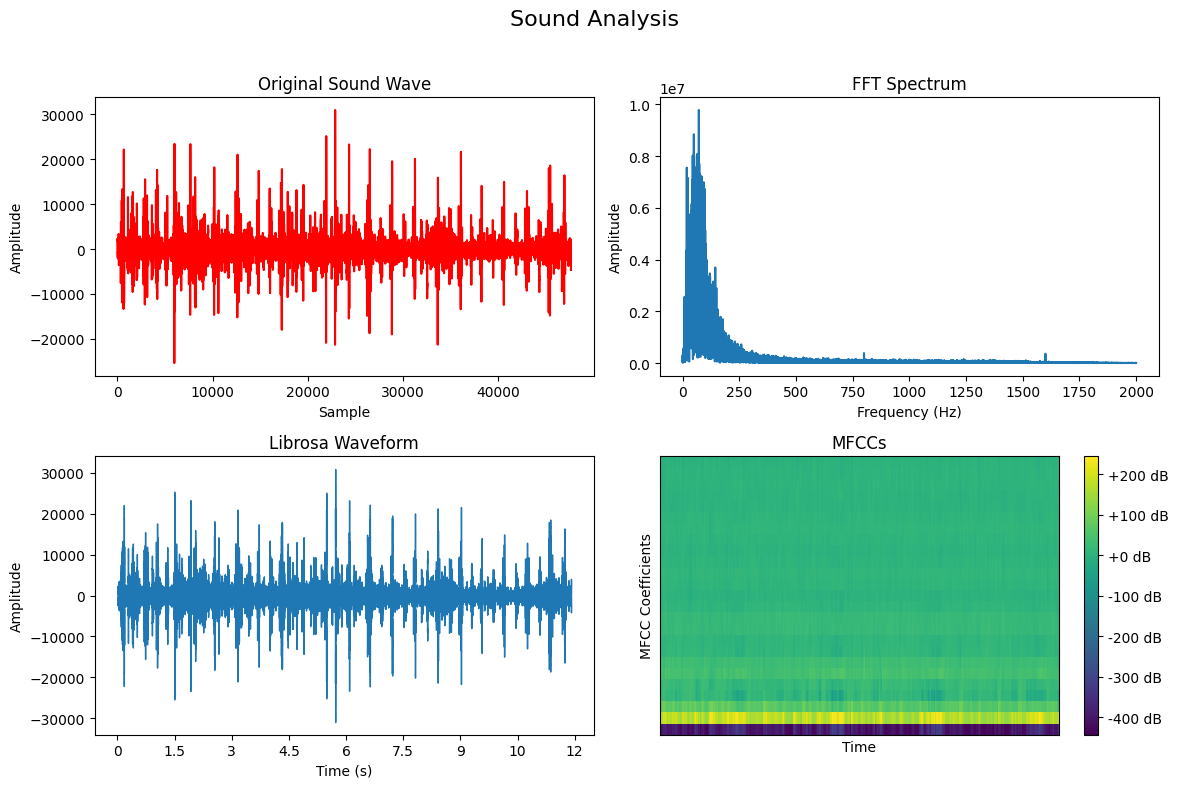

In [129]:
soundwave(r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\murmur_noisymurmur_135_1306428972976_C.wav')

### ExtraStole

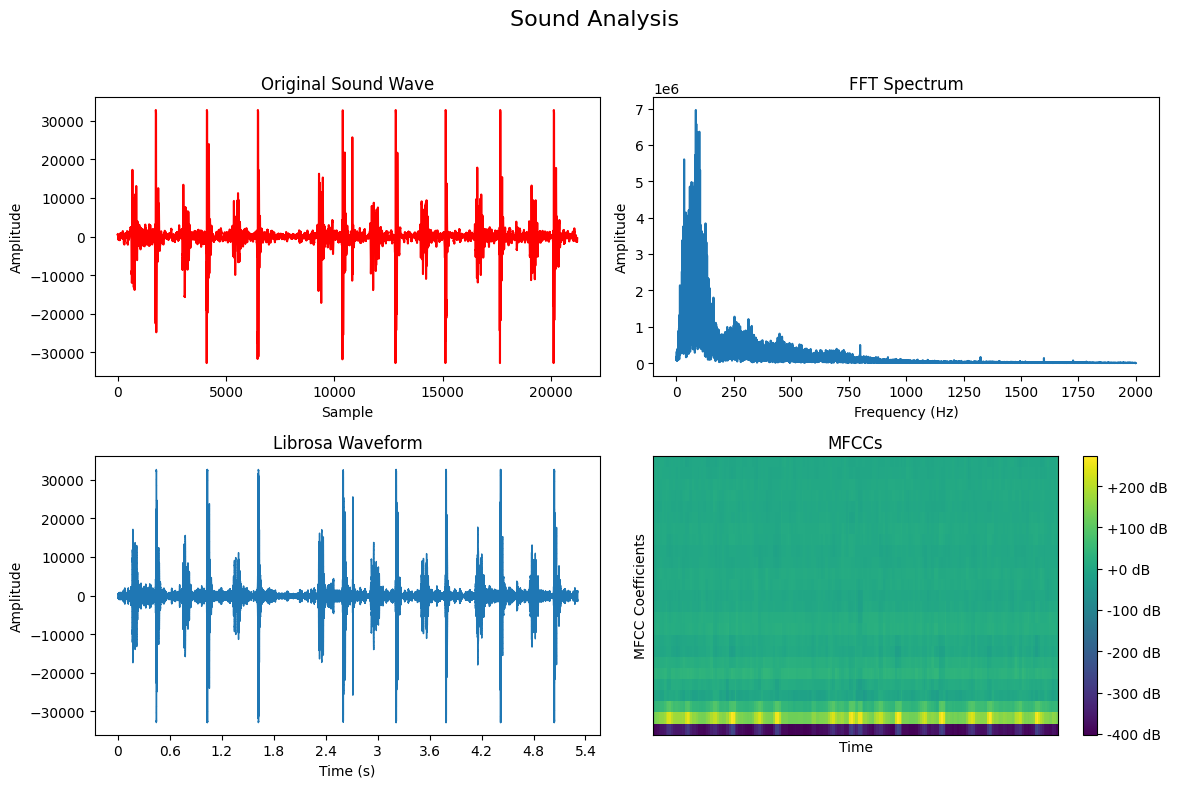

In [130]:
soundwave(r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\extrastole__220_1308250132896_B.wav')

### Extrahls

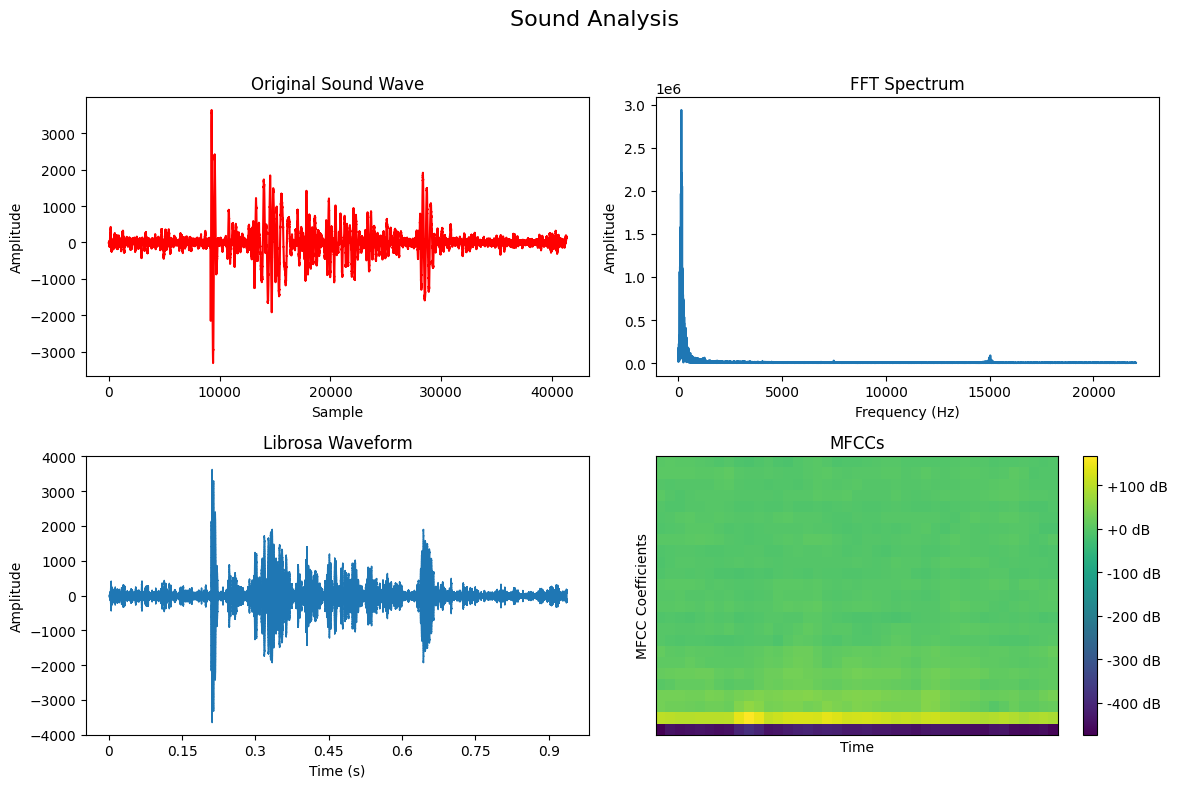

In [131]:
soundwave(r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\extrahls__201104021355 - Copy (2).wav')

### Artifact

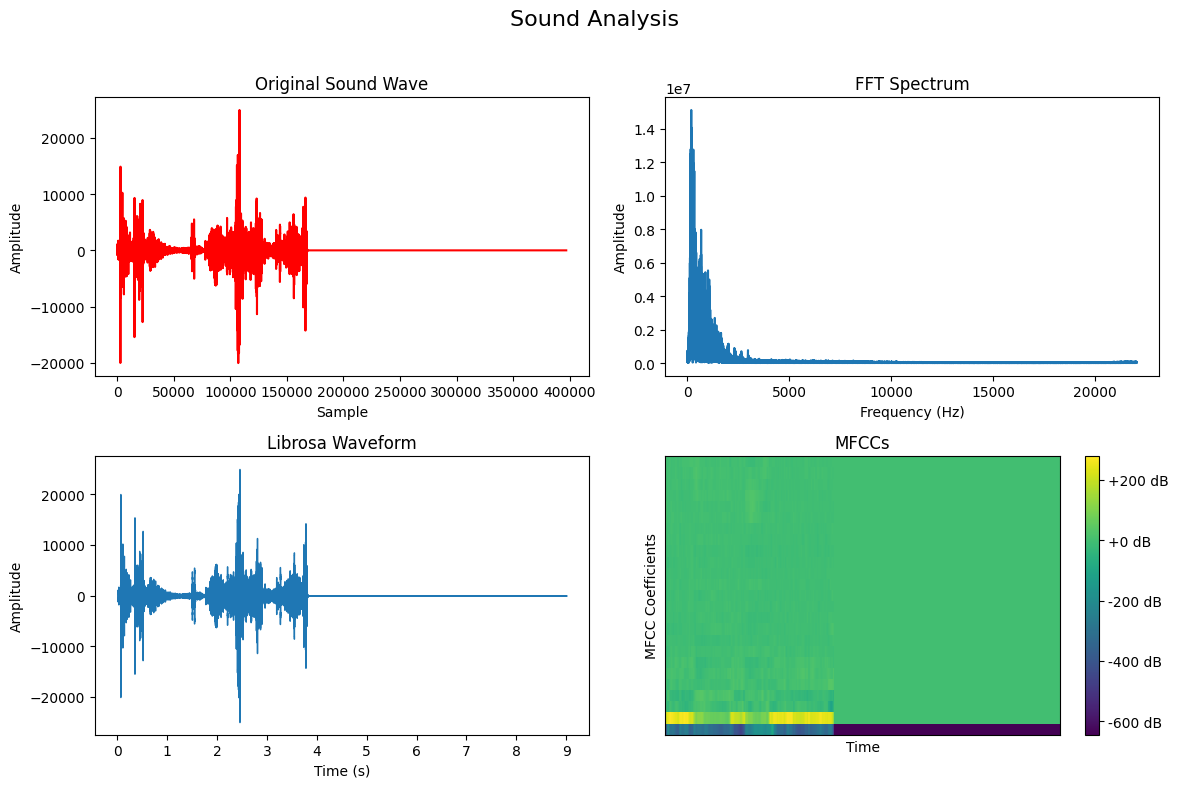

In [132]:
soundwave(r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\artifact__201106030612.wav')

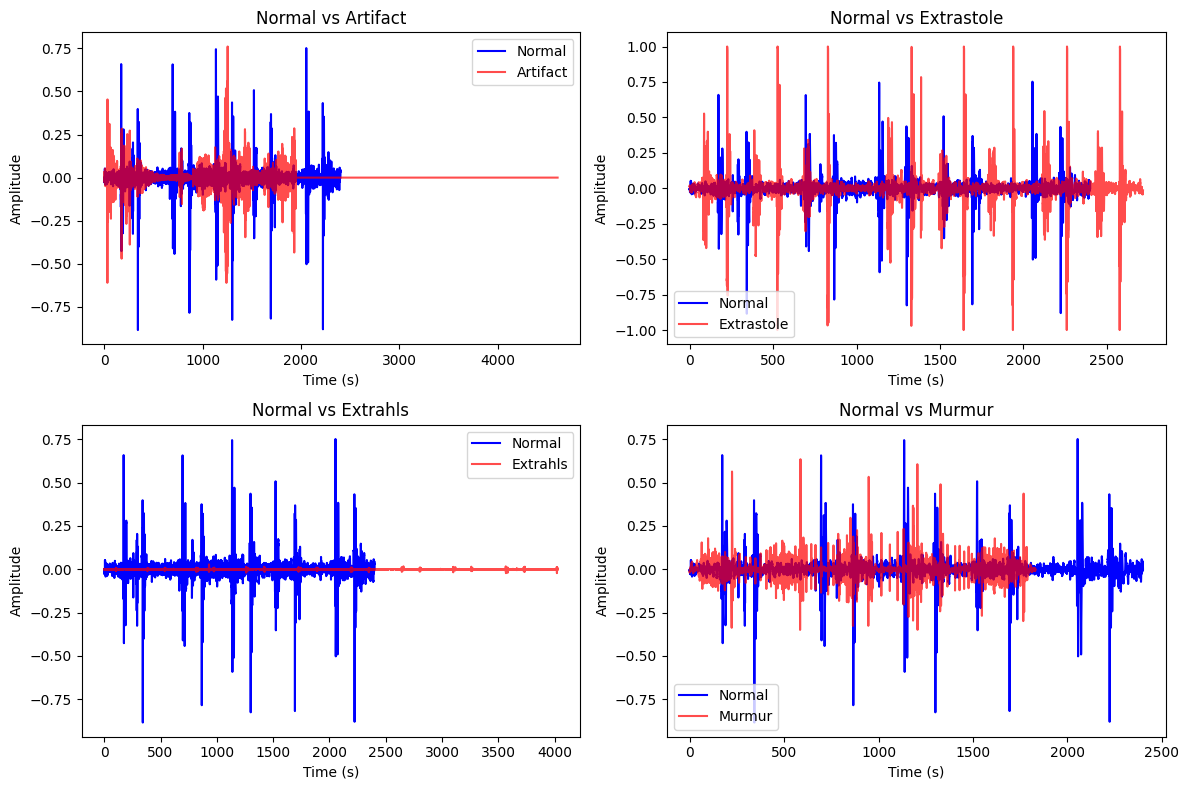

In [133]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the reference audio file
ref_file = r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\normal_noisynormal_198_1308141739338_D.wav'
y_ref, sr_ref = librosa.load(ref_file, sr=None)
time_ref = librosa.times_like(y_ref, sr=sr_ref)

# Load the four comparison audio files
comparison_files = [
    r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\artifact__201106030612.wav',
    r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\extrastole__220_1308250132896_B.wav',
    r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\extrahls__201102071835.wav',
    r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\wave\murmur_noisymurmur_165_1307109069581_C1.wav'
]

# Labels for the comparison files
comparison_names = ['Artifact', 'Extrastole', 'Extrahls', 'Murmur']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loop over the comparison files and plot each in a subplot
for i, (comp_file, comp_name) in enumerate(zip(comparison_files, comparison_names)):
    # Load the comparison audio file
    y_comp, sr_comp = librosa.load(comp_file, sr=None)
    time_comp = librosa.times_like(y_comp, sr=sr_comp)
    
    # Plot in the corresponding subplot
    ax = axes[i//2, i%2]  # Selects the subplot
    ax.plot(time_ref, y_ref, label='Normal', color='b')
    ax.plot(time_comp, y_comp, label=comp_name, color='r', alpha=0.7)
    
    # Add labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Normal vs {comp_name}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [134]:
import plotly.express as px

# Example DataFrame (replace with your actual DataFrame)
# df = pd.DataFrame({'label': ['artifact', 'extrahls', 'extrastole', 'murmur', 'normal', ...]})

fig = px.histogram(df, x='label', 
                   title='Distribution of Data Points by Label',
                   labels={'label': 'Label', 'count': 'Count'},
                   color_discrete_sequence=px.colors.sequential.Plasma)  # Change to a different color palette

fig.update_layout(xaxis_title='Label', yaxis_title='Count',
                  xaxis_tickangle=90, width=800, height=600)

# Data Preprocessing

In [135]:
X = df.drop("label", axis=1)
y = df['label']

# Preprocessing
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

# Split the data into training (80%), validation (10%), and testing (10%)
X_train, X_temp, y_train, y_temp = train_test_split(scaledX, y, random_state=42, train_size=0.8, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=42, train_size=0.5, shuffle=True)

In [136]:

pipeline_hgb = Pipeline([
    ('classifier', HistGradientBoostingClassifier())
])

pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipeline_svc = Pipeline([
    ('classifier', SVC())
])

# Hyperparameter grids
param_grid_hgb = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_iter': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7]
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['linear', 'rbf']
}


In [137]:
#Coarse-to-fine search: Randomized Search followed by Grid Search
def perform_search(pipeline, param_grid, X_train, y_train):
    # Randomized Search
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                       n_iter=10, cv=5, random_state=42)
    random_search.fit(X_train, y_train)
    
    
    best_params = random_search.best_params_
    print(f'Best parameters from Randomized Search: {best_params}')
    
    
    grid_search = GridSearchCV(pipeline, param_grid={key: [best_params[key]] for key in best_params},
                                cv=5)
    grid_search.fit(X_train, y_train)
    
   
    best_params_grid = grid_search.best_params_
    print(f'Best parameters from Grid Search: {best_params_grid}')
    
    return grid_search


# Perform searches for each model and print CV scores
def evaluate_model_and_print_cv_scores(model, X_train, y_train):
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=2)
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV score: {cv_scores.mean()}")
    except Exception as e:
        print(f"Error during cross-validation: {e}")




# Evaluate model and print confusion matrix for each classifier
def evaluate_model(grid_search, X_val, y_val, X_test, y_test):
    y_val_pred = grid_search.predict(X_val)
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, y_val_pred))

    cm_val = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix for Validation Set:")
    print(cm_val)

    y_test_pred = grid_search.predict(X_test)
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix for Test Set:")
    print(cm_test)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['artifact', 'extrahls', 'extrastole', 'murmur', 'normal'],
                yticklabels=['artifact', 'extrahls', 'extrastole', 'murmur', 'normal'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [138]:
# Perform searches for each model
print("HistGradientBoosting Classifier:")
grid_search_hgb = perform_search(pipeline_hgb, param_grid_hgb, X_train, y_train)
evaluate_model_and_print_cv_scores(grid_search_hgb, X_train, y_train)

print("\nRandomForest Classifier:")
grid_search_rf = perform_search(pipeline_rf, param_grid_rf, X_train, y_train)
evaluate_model_and_print_cv_scores(grid_search_rf, X_train, y_train)

print("\nSVC:")
grid_search_svc = perform_search(pipeline_svc, param_grid_svc, X_train, y_train)
evaluate_model_and_print_cv_scores(grid_search_svc, X_train, y_train)


# Define the label names based on your dataset
label_names = ["artifact", "extrahls", "extrastole", "murmur", "normal"]
    
# Evaluate all models
print("\nEvaluating HistGradientBoosting Classifier:")
evaluate_model(grid_search_hgb, X_val, y_val, X_test, y_test)

print("\nEvaluating RandomForest Classifier:")
evaluate_model(grid_search_rf, X_val, y_val, X_test, y_test)

print("\nEvaluating SVC:")
evaluate_model(grid_search_svc, X_val, y_val, X_test, y_test) 

HistGradientBoosting Classifier:
Best parameters from Randomized Search: {'classifier__max_iter': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2}
Best parameters from Grid Search: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__max_iter': 100}
Cross-validation scores: [0.74087591 0.72992701]
Mean CV score: 0.7354014598540146

RandomForest Classifier:
Best parameters from Randomized Search: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__max_depth': None}
Best parameters from Grid Search: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Cross-validation scores: [0.75182482 0.72262774]
Mean CV score: 0.7372262773722628

SVC:
Best parameters from Randomized Search: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 10}
Best parameters from Grid Search: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
C

### RandomForest Classifier:

- Best Mean CV Score: Achieved the highest mean cross-validation score (0.75), proving its strong generalization ability.
- Higher Recall for 'extrahls': Demonstrated superior recall (100% on the test set) for 'extrahls,' essential for minimizing false negatives.
- Feature Importance Insight: Can identify critical features, aiding in understanding key characteristics of heartbeat audio.

### SVC:

- Balanced Performance Across Classes: Maintained consistent accuracy (77-81%) on validation and test sets, showing stable results.
- Effective for Overlapping Classes: The 'rbf' kernel helped in distinguishing similar classes like 'murmur' and 'normal,' reducing misclassification.
- Good Recall for 'normal': Achieved 82% recall for 'normal' on the test set, ensuring fewer missed cases.

# Stacking

In [139]:

base_models = [
    ('random_forest', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)),
    ('svc', SVC(C=1, probability=True, kernel='rbf', random_state=42))
]

meta_model = OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=500))

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)


stacking_model.fit(X_train, y_train)


y_val_pred = stacking_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))


y_test_pred = stacking_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))


Validation Accuracy: 0.8235294117647058

Validation Classification Report:
               precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         8
    extrahls       1.00      0.62      0.77         8
  extrastole       1.00      0.88      0.93         8
      murmur       1.00      0.58      0.73        19
      normal       0.68      1.00      0.81        25

    accuracy                           0.82        68
   macro avg       0.94      0.82      0.85        68
weighted avg       0.88      0.82      0.82        68

Test Accuracy: 0.782608695652174

Test Classification Report:
               precision    recall  f1-score   support

    artifact       1.00      0.89      0.94         9
    extrahls       0.71      0.83      0.77         6
  extrastole       1.00      0.67      0.80         9
      murmur       1.00      0.47      0.64        17
      normal       0.68      0.96      0.79        28

    accuracy                           0.78   

- Higher Recall:

'Normal' Class Recall: 1.00 (validation), 0.96 (test) — better identification of true positives.

- Enhanced F1 Scores:

Validation: 'extrahls' (0.77), 'extrastole' (0.93), 'murmur' (0.73)
Test: 'extrahls' (0.77), 'extrastole' (0.80), 'murmur' (0.64)
Balances precision and recall effectively.

- Robust Performance Across Classes:

High precision for 'artifact' (1.00), while improving recall in other classes.

- Good Generalization:

Accuracy: 82.35% (validation), 78.26% (test) — shows the model's ability to perform well on unseen data.

# Voting

In [140]:
hist_gradient_boosting = HistGradientBoostingClassifier(max_iter=100, max_depth=5, learning_rate=0.2)
random_forest = RandomForestClassifier(n_estimators=50, min_samples_split=2, max_depth=None)
svc = SVC(kernel='rbf', gamma='scale', C=10, probability=True)  # Set probability=True for soft voting

# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('hist_gradient_boosting', hist_gradient_boosting),
        ('random_forest', random_forest),
        ('svc', svc)
    ],
    voting='soft' 
)


voting_clf.fit(X_train, y_train)


y_val_pred = voting_clf.predict(X_val)


y_test_pred = voting_clf.predict(X_test)


print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Validation Set Classification Report:
              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         8
    extrahls       0.80      0.50      0.62         8
  extrastole       1.00      0.88      0.93         8
      murmur       1.00      0.53      0.69        19
      normal       0.63      0.96      0.76        25

    accuracy                           0.78        68
   macro avg       0.89      0.77      0.80        68
weighted avg       0.84      0.78      0.77        68

Validation Set Confusion Matrix:
[[ 8  0  0  0  0]
 [ 0  4  0  0  4]
 [ 0  0  7  0  1]
 [ 0  0  0 10  9]
 [ 0  1  0  0 24]]
Test Set Classification Report:
              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         9
    extrahls       0.57      0.67      0.62         6
  extrastole       1.00      0.78      0.88         9
      murmur       0.89      0.47      0.62        17
      normal       0.70      0.93      0.80   

Accuracy and other perameters are similar after voting ensemble technique.

# Boosting and Stacking

In [141]:
hist_gradient_boosting = HistGradientBoostingClassifier(max_iter=100, max_depth=5, learning_rate=0.2)
random_forest = RandomForestClassifier(n_estimators=50, min_samples_split=2, max_depth=None)
svc = SVC(kernel='rbf', gamma='scale', C=10, probability=True)  # Set probability=True for soft voting

# Create AdaBoost classifiers for stacking, specifying the algorithm
ada_hist = AdaBoostClassifier(estimator=hist_gradient_boosting, n_estimators=50, algorithm='SAMME')
ada_rf = AdaBoostClassifier(estimator=random_forest, n_estimators=50, algorithm='SAMME')
ada_svc = AdaBoostClassifier(estimator=svc, n_estimators=50, algorithm='SAMME')

# Create the stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('ada_hist', ada_hist),
        ('ada_rf', ada_rf),
        ('ada_svc', ada_svc)
    ],
    final_estimator=OneVsRestClassifier(SVC(probability=True))  
)


stacking_clf.fit(X_train, y_train)


y_val_pred = stacking_clf.predict(X_val)
y_test_pred = stacking_clf.predict(X_test)


print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation Set Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Validation Set Classification Report:
              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         8
    extrahls       0.83      0.62      0.71         8
  extrastole       1.00      0.88      0.93         8
      murmur       1.00      0.47      0.64        19
      normal       0.63      0.96      0.76        25

    accuracy                           0.78        68
   macro avg       0.89      0.79      0.81        68
weighted avg       0.84      0.78      0.77        68

Validation Set Confusion Matrix:
[[ 8  0  0  0  0]
 [ 0  5  0  0  3]
 [ 0  0  7  0  1]
 [ 0  0  0  9 10]
 [ 0  1  0  0 24]]
Test Set Classification Report:
              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         9
    extrahls       0.71      0.83      0.77         6
  extrastole       1.00      0.78      0.88         9
      murmur       1.00      0.41      0.58        17
      normal       0.69      0.96      0.81   

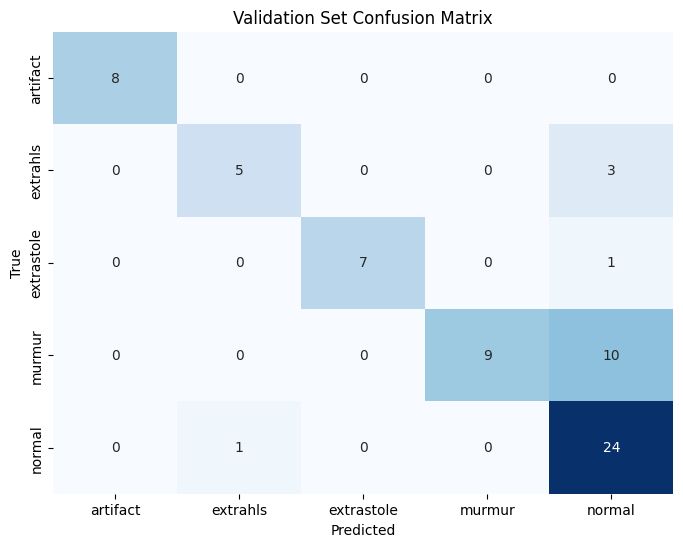

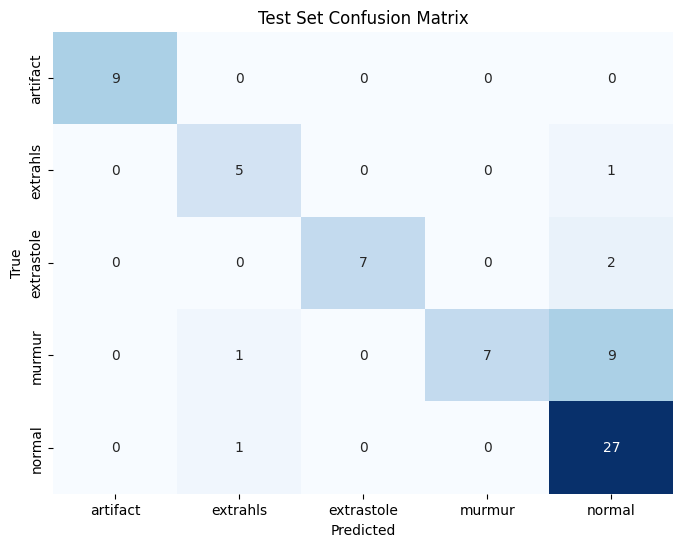

In [142]:
plot_confusion_matrix(y_val, y_val_pred, title='Validation Set Confusion Matrix')


plot_confusion_matrix(y_test, y_test_pred, title='Test Set Confusion Matrix')

We apply Boosting on individual model(Randomforest,SVC,histGradientBoosting).

Then took this model as base model for stacking.

We choose OneVsRest logistic regression model as meta model.

# Key Observations:
- High Precision and Recall for 'artifact' Class: The model performed exceptionally well in identifying the 'artifact' class with a perfect precision and recall of 1.00.
- Moderate Performance for 'murmur' Class: The 'murmur' class showed lower recall (0.41) in both validation and test sets, indicating that some instances were misclassified. Further tuning may be necessary to improve detection.
- Overall Accuracy Improvement: The stacking classifier achieved an 80% accuracy on the test set, indicating strong generalization capability over unseen data.
- Balanced Class Representation: The model managed to maintain a balance in performance across different classes, as seen in the macro averages.

In [143]:
best_model=stacking_clf

In [144]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the validation and test sets
y_val_prob = stacking_clf.predict_proba(X_val)  
y_test_prob = stacking_clf.predict_proba(X_test)  

# Assuming you have a list of class labels
class_labels = ['artifact', 'extrahls', 'extrastole', 'murmur', 'normal']
n_classes = len(class_labels)

# For storing ROC curves and AUC values
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == class_labels[i], y_test_prob[:, i])  

# Creating the Plotly figure
fig = go.Figure()


for i in range(n_classes):
    fig.add_trace(go.Scatter(
        x=fpr[i],
        y=tpr[i],
        mode='lines',
        name='ROC curve for class {} (area = {:.2f})'.format(class_labels[i], roc_auc[i]),
        line=dict(width=2)
    ))

# Add the diagonal line (random guess)
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random guess',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curves for Multi-Class',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    template='plotly'
)


fig.show()


# Prediction On unseen data:

### Real audio file of young person

In [145]:
import numpy as np
import librosa

def extract_features_from_wavefile(filename):
    try:
        y, sr = librosa.load(filename)

    
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=100), axis=1)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85))
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

        
        features = np.hstack([mfcc, [zero_crossing_rate, centroid, rolloff, chroma]])
        return features

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

def predict_wave_file_class(stacking_clf, filename):
 
    features = extract_features_from_wavefile(filename)
    
    if features is not None:
        # Reshape for model input
        features = features.reshape(1, -1)  
        
        # Predict class
        prediction = stacking_clf.predict(features)
        print(f"Predicted class for {filename}: {prediction[0]}")
        return prediction[0]
    else:
        print("Feature extraction failed, skipping prediction.")
        return None

In [146]:
predict_wave_file_class(stacking_clf, r'C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\Unseen data\WhatsApp Audio 2024-09-30 at 11.07.17_e33289a3.dat.wav')

Predicted class for C:\Users\krish\OneDrive\Documents\DAIICT\SEM 1\ml\Visinory vectores - 1\Classification_Final\Unseen data\WhatsApp Audio 2024-09-30 at 11.07.17_e33289a3.dat.wav: normal


'normal'